# Setup

In [2]:
!git clone https://github.com/shawdsai/sigma-capstone-project

fatal: destination path 'sigma-capstone-project' already exists and is not an empty directory.


In [3]:
# Define models' paths
logreg_path = "/content/sigma-capstone-project/models/logreg.onnx"
mnb_path = "/content/sigma-capstone-project/models/mnb.onnx"
sentence_bias_model_path = "/content/sigma-capstone-project/models/sentence_bias_model"

In [4]:
!pip install -q pyspark==3.5.5 spark-nlp==5.5.3
!pip install skl2onnx
!pip install onnxruntime-gpu
!pip install tldextract
!pip3 install newspaper3k
!pip install --upgrade lxml_html_clean

# Can also use the script below but the pyspark version is incompatible.
# !wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have p

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=f4c8b360fa1182978cac30edfe6aeac27edd293f57b1de01873867019e06e9c3
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created whe

In [5]:
import sparknlp

spark = sparknlp.start(gpu=True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.5.3
Apache Spark version: 3.5.5


In [6]:
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import ast
from sparknlp.annotator import StopWordsCleaner
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sparknlp.annotator import StopWordsCleaner
from pyspark.ml import Pipeline
from sparknlp.base import LightPipeline
import os
import pandas as pd
import json
import joblib
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import numpy
import newspaper
from newspaper import Article, Config

In [7]:
sample_text = """
Most taxpayers will get a check from the $2tn economic package, the largest in US history

US coronavirus stimulus checks: are you eligible and how much will you get?

The US has agreed on a $2tn stimulus package, the largest economic stimulus in US history, in response to the economic impacts of Covid-19. While corporations will be the biggest recipients of the bailout, some of that money will be paid directly to Americans hit by the pandemic.

Most taxpayers will get a check in the mail, while those directly affected by the economic effects of Covid-19 are slated to receive robust government support.

Here’s what we know so far about how the new stimulus package will directly affect Americans in the coming weeks:

Who’s eligible for a check from the government?

Congress will spend about $250bn for checks up to $1,200 per person that will go directly to taxpayers.

To be eligible for the full amount, a person’s most recently filed tax return must show that they made $75,000 or under. For couples, who can receive a maximum of $2,400, the cutoff is $150,000.

If a person makes more than $75,000, the amount given goes down incrementally by $5 for every $100 increase in salary. So a person who makes $85,000 would get $700 while a person who makes $95,000 would get $200.

If a person makes above $99,000, or a couple makes above $198,000, no check will be given.

There are some requirements and exceptions. Those getting a check must be living and working in the US and have a valid social security number. If a person is listed as a dependent on their parents’ tax return – the case for many college students – they are excluded.

The Tax Foundation, a DC-based thinktank, estimates that 93.6% of Americans will be eligible for a check coming from the stimulus package.

What about parents?

Taxpayers will be given $500 per child 16 or under listed as a dependent on their latest tax return.

When will I get this money?

That is still unclear. Experts say that Americans will probably not get the money until May, given how long it takes the Internal Revenue Service (IRS) to send out checks. The treasury secretary, Steven Mnuchin, said those whose bank account information is already with the IRS from previous tax returns can expect a payment “within three weeks”.

For those who still need to give the IRS their bank account information, a web-based portal will be opening soon to allow people to provide the IRS with their information. The IRS says this is to make sure people get their checks immediately, instead of sending them through the mail.

This is not the first time the government has sent checks to Americans. The federal government gave up to $300 in 2001 and $600 in 2008 to taxpayers who met a certain income bracket to similarly stimulate the economy.

What if a person did not file their 2018 or 2019 return?

The IRS recommends people file their 2018 or 2019 tax return as soon as possible to get the payment. A check will be sent to any qualified person so long as they file their return within 2020.

What if a person does not file their taxes?

A person may still be eligible even if they do not file the taxes. The IRS says people who typically do not file taxes – low-income taxpayers and some veterans – will need to file a “simple tax return” in order to get the payment. Social security beneficiaries will not need to fill out the tax return, even if they do not file their taxes, to get the payment.

Does the package help unemployed workers?

Yes, specifically the bill will increase unemployment insurance by $600 for 13 weeks – about four months – for every person, added to the existing unemployment compensation a person gets from their state’s program.

The length and amount of compensation varies from state to state. A majority of states providing a maximum of 26 weeks of compensation, while average weekly compensation ranges from 20% of a person’s wage to just over 50%.

What about freelance and gig workers?

While unemployment insurance typically does not cover people who are self-employed – freelancers, contractors and gig workers – the bill comes with a “pandemic unemployment assistance” measure that will extend insurance to those workers.

Play Video 2:25 'The universe is collapsing': Bernie Sanders mocks Republicans over coronavirus aid – video

Have there been any changes to paid leave?

Not in this bill. Earlier last week, Donald Trump signed the Families First Coronavirus Response Act, a bill worth about $100bn meant to expand paid sick leave and emergency paid leave, but it came with major loopholes. Companies with over 500 employees were not mentioned in the bill, while companies with under 50 employees can apply for exemptions.

The bill mandates 10 days of fully paid sick leave for employees of companies with 500 employees or less. Parents of those companies affected by their children’s school closing and those leaving for medical reasons can get 12 weeks of pay at 67% of their salary.

Will there be anything to offset healthcare costs related to Covid-19?

Again, not in this bill. The Families First Coronavirus Response Act included a measure that mandated all Covid-19 testing is free, but treatment for any symptoms (there is currently no cure for the illness) still comes at a cost.

A few states have reopened enrollment for their health insurance programs to allow those concerned about costs to enroll, and three major health insurance companies said they will be waiving any high costs for treatment, but there are still stories of people getting bills for as much as $34,000 to cover treatment of the virus’s symptoms.
"""

In [8]:
def init_clean_text_pipeline(text):
  nlp_pipeline = PretrainedPipeline("explain_document_ml", lang="en")
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_iso', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens")
  default_stages = nlp_pipeline.model.stages
  custom_pipeline = Pipeline(stages=default_stages + [stopwords_cleaner])
  pipeline_model = custom_pipeline.fit(spark.createDataFrame([[text]]).toDF("text"))
  light_model = LightPipeline(pipeline_model, parse_embeddings=True)
  return light_model


clean_text_pipeline = init_clean_text_pipeline(sample_text)

explain_document_ml download started this may take some time.
Approx size to download 9 MB
[OK!]
stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [9]:
# Define a function that takes an original text and returns a cleaned version
def clean_text(text, light_model=clean_text_pipeline, remove_stop_words=False, fix_spelling=False, join=True, delimiter=" "):
  result = light_model.annotate(text)
  output_col = 'cleanTokens' if remove_stop_words else ('spell' if fix_spelling else 'token')
  return delimiter.join(result[output_col]) if join else result[output_col]

In [10]:
# Example 1: returning original with space characters as delimiter
text = clean_text("Hello, my name is Jitrapon. I am studying Capstone. This is a very fun project! Thre is some spellling errors!")
assert(text == 'Hello , my name is Jitrapon . I am studying Capstone . This is a very fun project ! Thre is some spellling errors !')

# Example 2: returning text with space characters as delimiter but also fix spelling
text = clean_text("Hello, my name is Jitrapon. I am studying Capstone. This is a very fun project! Thre is some spellling errors!", fix_spelling=True)
assert(text == 'Hello , my name is Jitrapon . I am studying Capstone . This is a very fun project ! There is some spelling errors !')

# Example 3: returning a list instead
text_list = clean_text("Hello, my name is Jitrapon. I am studying Capstone. This is a very fun project!", join=False)
assert(text_list == ['Hello',
 ',',
 'my',
 'name',
 'is',
 'Jitrapon',
 '.',
 'I',
 'am',
 'studying',
 'Capstone',
 '.',
 'This',
 'is',
 'a',
 'very',
 'fun',
 'project',
 '!'])

# Example 4: remove all stopwords
text = clean_text("Hello, my name is Jitrapon. I am studying Capstone. This is a very fun project!", remove_stop_words=True)
assert(text == 'Hello , Jitrapon . studying Capstone . fun project !')

# Example 5: using comma as a delimiter
text = clean_text("Hello, my name is Jitrapon. I am studying Capstone. This is a very fun project!", delimiter=",")
assert(text == 'Hello,,,my,name,is,Jitrapon,.,I,am,studying,Capstone,.,This,is,a,very,fun,project,!')

In [11]:
# Load the sentence-biase classifier
from pyspark.ml import PipelineModel


sentence_bias_model = PipelineModel.load(sentence_bias_model_path)

In [12]:
# Load the source_bias_score.csv to Pandas
path = F"/content/sigma-capstone-project/data/source_bias_score.csv"
source_bias_score_df = pd.read_csv(path)
source_bias_score_df.drop(columns=['Unnamed: 0'], inplace=True)
source_bias_score_df.head()

,domain,source,count,source_encoded,source_bias_score
0,aljazeera,Al Jazeera,104,4.0,0.5
1,allsides,National Review,3,108.0,1.5
2,apnews,Associated Press,235,14.0,0.0
3,axios,Axios,62,15.0,0.5
4,bbc,BBC News,603,16.0,1.0


In [13]:
from tldextract import extract
import numpy as np


# Define a function that extracts the domain from the URL, then returns the corresponding 'source', 'source_encoded', and 'source_bias_score'
def convert_url_to_source(url):
  ext = extract(url)
  # Return the row in source_bias_score_df where domain equals ext.domain
  return source_bias_score_df[source_bias_score_df['domain'] == ext.domain]


assert(0.5 == convert_url_to_source('www.cnn.com')['source_bias_score'].values[0])

In [14]:
# Load test_pd_df_final from csv
path = F"/content/sigma-capstone-project/data/test_pd_df_final.csv"
test_pd_df_final = pd.read_csv(path)
test_pd_df_final.head()

,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,source_bias_score,source_encoded,avg_sentence_bias_score
0,0,palestine,Breitbart News,2.0,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,2.0,8.0,0.718750
1,1,federal_budget,ABC News,0.0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0.5,0.0,0.450000
2,2,fbi,Reuters,1.0,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,1.0,23.0,0.366667
3,3,politics,CBN,2.0,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,2.0,10.0,0.400000
4,4,media_bias,Breitbart News,2.0,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,2.0,8.0,0.620690


In [15]:
# Load the TF-IDF vectorizer
path = F"/content/sigma-capstone-project/models/tfidf_vectorizer.pkl"
tfidf_vectorizer = joblib.load(path)

In [16]:
# Load the Scaler
path = F"/content/sigma-capstone-project/models/scaler.pkl"
scaler = joblib.load(path)

In [17]:
# Define a function that preprocesses all the columns to be predicted
def preprocess_test_columns(df=test_pd_df_final, vectorizer=tfidf_vectorizer, scaler=scaler, addition_features=True):
  X = df["content"]
  y = df["bias"]

  # Create a TF-IDF vectorizer from the text from the fitted vectorizer
  X_text = vectorizer.transform(df['content'])

  if addition_features:

    # Prepare the additional numeric features.
    additional_features = df[['avg_sentence_bias_score', 'source_encoded', 'source_bias_score']].values

    # Standardize these features to put them on a similar scale.
    X_additional_scaled = scaler.transform(additional_features)

    # Convert the additional features to a sparse matrix.
    X_additional_sparse = csr_matrix(X_additional_scaled)

    # Combine the TF-IDF features with the additional features.
    X_final = hstack([X_text, X_additional_sparse])
  else:
    X_final = X_text

  # Get the target variable.
  y = df['bias']

  return (X_final, y)

In [18]:
# Define a function that prints out accuracy report
def print_accuracy_report(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print("Accuracy: {:.3f}\n".format(accuracy))
  print(report)

In [19]:
# Load the saved models
# https://onnx.ai/sklearn-onnx/auto_examples/plot_convert_model.html
import onnx
import onnxruntime as rt


# Preprocess the test dataset
X_test, y_test = preprocess_test_columns()

# Test prediction with ONNX runtime
def predict(X_test, model_path):
  sess = rt.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
  input_name = sess.get_inputs()[0].name
  label_name = sess.get_outputs()[0].name
  pred_onx = sess.run([label_name], {input_name: (X_test.astype(numpy.float32)).toarray()})[0]
  return pred_onx

In [20]:
# Make sure that the prediction is what we expect
print_accuracy_report(y_test, predict(X_test, logreg_path))

Accuracy: 0.869

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89       402
         1.0       0.71      0.73      0.72       298
         2.0       1.00      0.87      0.93       599

    accuracy                           0.87      1299
   macro avg       0.85      0.86      0.85      1299
weighted avg       0.88      0.87      0.87      1299



In [21]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StringType, IntegerType


# Setup pipeline to extract sentences out of each article
document = DocumentAssembler() \
    .setInputCol('content') \
    .setOutputCol("document")

# Using setExplodeSentences(True) will create one row per sentence.
sentence_detector = SentenceDetectorDLModel() \
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols("document") \
    .setOutputCol("sentence") \
    .setExplodeSentences(True)

sentence_detector_pipeline = Pipeline(
    stages=[
        document,
        sentence_detector
])

# Define a UDF to extract the sentence from each annotation in an array.
def extract_sentence_text(annotations):
    if annotations is None:
        return []
    for ann in annotations:
      return ann.result

extract_sentence_text_udf = udf(extract_sentence_text, StringType())

# Define a UDF to extract the bias value
def extract_result(result):
    return int(result[0].get)

extract_result_udf = udf(extract_result, IntegerType())

# To use, uncomment
# exploded_test_df = sentence_detector_pipeline.fit(test_df).transform(test_df)
# exploded_test_df = exploded_test_df.withColumn("text", extract_sentence_text_udf(col("sentence")))

# Use the sentence-level bias classifier to predict the bias
# exploded_test_df = sentence_bias_model.transform(exploded_test_df)

# exploded_test_df = exploded_test_df.withColumn("sentence_bias_score", extract_sentence_text_udf(col("class")))
# exploded_test_df.select('ID', 'text', 'sentence_bias_score').show(truncate=False)

# Compute the average bias score
# agg_test_df = exploded_test_df.groupBy("ID") \
    # .agg(mean(col("sentence_bias_score")).alias("avg_sentence_bias_score"))

# Retrieve the average bias score

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [22]:
from pyspark.sql.functions import avg, round, col, mean


# Define a function that takes in the preprocessed text
# and returns the computed average bias score for the article
def compute_avg_sentence_bias_score(text, debug=False):
  # Create a Spark DataFrame
  test_df = spark.createDataFrame([[text]], ["content"])

  # Extract sentences into a new column called 'text'
  exploded_test_df = sentence_detector_pipeline.fit(test_df).transform(test_df)
  exploded_test_df = exploded_test_df.withColumn("text", extract_sentence_text_udf(col("sentence")))

  # Use the sentence-level bias classifier to predict the bias
  exploded_test_df = sentence_bias_model.transform(exploded_test_df)
  exploded_test_df = exploded_test_df.withColumn("sentence_bias_score", extract_sentence_text_udf(col("class")))

  if debug:
    exploded_test_df.select('text', 'sentence_bias_score').show(truncate=False)

  # Compute the average bias score
  agg_test_df = exploded_test_df\
      .agg(mean(col("sentence_bias_score")).alias("avg_sentence_bias_score"))

  # Retrieve the average bias score
  return agg_test_df.select("avg_sentence_bias_score").collect()[0][0]

In [23]:
%%time

assert(0.14285714285714285 == compute_avg_sentence_bias_score(sample_text, True))

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|text                                                                                                                                                           |sentence_bias_score|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|Most taxpayers will get a check from the $2tn economic package, the largest in US history                                                                      |0                  |
|US coronavirus stimulus checks: are you eligible and how much will you get?                                                                                    |0                  |
|The US has agreed on a $2tn stimulus package, the largest economic stimulus in US history

In [24]:
# Make sure that the prediction is what we expect
print_accuracy_report(y_test, predict(X_test, mnb_path))

Accuracy: 0.834

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.81       402
         1.0       0.81      0.72      0.76       298
         2.0       0.97      0.83      0.90       599

    accuracy                           0.83      1299
   macro avg       0.83      0.83      0.82      1299
weighted avg       0.85      0.83      0.84      1299



# Pipeline

In [25]:
url_list = [
    'https://edition.cnn.com/2024/11/06/politics/trump-wins-election/index.html',
    'https://apnews.com/article/election-2024-voter-turnout-republicans-trump-harris-7ef18c115c8e1e76210820e0146bc3a5',
    'https://apnews.com/article/debate-trump-biden-presidential-campaign-44e71c900a1c4af2bed93041fdfe923d',
    'https://edition.cnn.com/2024/11/09/us/4b-movement-trump-south-korea-wellness-cec/index.html',
    'https://edition.cnn.com/2024/12/27/economy/politics-wars-global-economy-2025-intl/index.html',
    'https://edition.cnn.com/2024/04/16/business/corporate-america-abortion-activism-nightcap/index.html',
    'https://edition.cnn.com/2024/11/06/politics/harris-campaign-went-wrong/index.html',
    'https://apnews.com/article/new-york-ballot-measure-abortion-transgender-c6fa789a0f98da44eb52b74eb25e4b80',
    'https://apnews.com/article/abortion-election-harris-trump-women-north-carolina-f14edf1e33c367a430784f7848834514',
    'https://apnews.com/article/poll-race-ethnicity-economy-immigration-foreign-policy-dbf7ec76f8b1caa2ba44a3078ca2e6fe',
    'https://www.forbes.com/sites/saradorn/2024/11/05/trump-vs-harris-2024-polls-trump-up-in-3-new-surveys-harris-leads-in-2-others',
    'https://www.forbes.com/sites/alisondurkee/2024/11/04/trump-vs-harris-fundraising-race-harris-outraised-trump-3-to-1-with-last-pre-election-report/?utm_source=chatgpt.com',
    'https://www.forbes.com/sites/vipinbharathan/2024/09/17/puncturing-the-phillips-curve-myth',
    'https://www.forbes.com/sites/dereksaul/2024/10/01/defense-stocks-hit-all-time-highs-amid-middle-east-escalation',
    'https://www.forbes.com/sites/pamdanziger/2024/05/16/how-target-found-middle-ground-for-pride-month-2024-and-others-can-do-the-same',
    'https://www.bbc.com/news/articles/c4ng1my55vno',
    'https://www.bbc.com/news/articles/cn9l9500vg7o',
    'https://www.bbc.com/news/world-61759692',
    'https://www.bbc.com/news/articles/cd0gelezlevo',
    'https://www.bbc.com/news/articles/cpvvvl9zq4eo',
    'https://www.foxnews.com/politics/trump-biden-supporters-sharply-divided-over-culture-war-woke-issues-heres-where-stand',
    'https://www.foxnews.com/politics/fox-news-voter-analysis-how-trump-regained-white-house',
    'https://www.foxnews.com/media/voters-weigh-state-biden-harris-economy-inflation-killing-us',
    'https://www.foxnews.com/media/james-carville-says-americas-woke-hangover-haunted-harris-campaign-damaged-democratic-brand',
    'https://www.foxnews.com/politics/pro-life-conservatives-are-disappointed-in-trumps-new-abortion-policy-but-stick-by-him-only-one-optiopn',
    'https://www.theepochtimes.com/us/2024-election-campaigns-a-rocky-road-to-the-white-house-5751930',
    'https://www.theepochtimes.com/us/harris-outraises-trump-in-last-weeks-of-election-season-5754432',
    'https://www.theepochtimes.com/business/twelve-or-more-reasons-to-expect-a-prosperous-2024-post-5554140',
    'https://www.theepochtimes.com/us/heres-whats-in-the-895-billion-defense-authorization-bill-5773209',
    'https://www.theepochtimes.com/us/harley-davidson-disavows-dei-goals-amid-social-media-backlash-5709058',
]
url = url_list[-1]

In [26]:
# Load the full text from the article
config = Config()
config.browser_user_agent = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:108.0) Gecko/20100101 Firefox/108.0"
article = Article(url, config=config)
article.download()
article.parse()
text = article.text

In [27]:
# Clean text
text = clean_text(text)
text

'The motorcycle maker said it will focus on growing the sport of motorcycling and retaining customers . Harley-Davidson has clarified its stance on diversity , equity , and inclusion ( DEI ) goals and initiatives amid what it described as “negativity on social media . ” The company said in an Aug . 19 statement that it initiated an internal review earlier in the year to “better align Company activities to the needs of both our business and community . ” Following the review , the company said it would end its relationship with the Human Rights Campaign , the nation’s largest LGBT advocacy group . Addressing concerns about its employee training programs , the company said that all training initiatives will now be strictly business-focused and free from “socially motivated” content . Harley-Davidson also said it would review all sponsorships and outside organizations the company is affiliated with . The Milwaukee-based company had previously been a corporate member of the Wisconsin LBGT 

In [28]:
%%time

# Compute average sentence bias score
avg_sentence_bias_score = compute_avg_sentence_bias_score(text, True)
avg_sentence_bias_score

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

0.14285714285714285

In [29]:
# From the URL, convert to one of the sources from the training data, if none found use BBC's center rating
row = convert_url_to_source(url)
if row.empty:
  source_encoded = 603
  source_bias_score = 1.0
else:
  source_encoded = row['source_encoded'].values[0]
  source_bias_score = row['source_bias_score'].values[0]

In [30]:
# Create a Pandas DataFrame from the text, avg_sentence_bias_score, source_encoded, and source_bias_score
test_pd_df = pd.DataFrame({
    'content': [text],
    'avg_sentence_bias_score': [avg_sentence_bias_score],
    'source_encoded': [source_encoded],
    'source_bias_score': [source_bias_score],
    'bias': [-1]
    })
test_pd_df

,content,avg_sentence_bias_score,source_encoded,source_bias_score,bias
0,The motorcycle maker said it will focus on gro...,0.142857,156.0,1.5,-1


In [31]:
# Pass the DataFrame and generate Sparse Matrix from the columns
X_test, y_test = preprocess_test_columns(test_pd_df, addition_features=True)
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (1, 50003)>

In [32]:
# Predict
y_pred = int(predict(X_test, logreg_path)[0])

# Map the int back to leaning
if y_pred == 0:
  leaning = 'left'
elif y_pred == 1:
  leaning = 'center'
else:
  leaning = 'right'
{ 'bias': y_pred, 'leaning': leaning }

{'bias': 2, 'leaning': 'right'}

In [33]:
# Predict
y_pred = int(predict(X_test, mnb_path)[0])

# Map the int back to leaning
if y_pred == 0:
  leaning = 'left'
elif y_pred == 1:
  leaning = 'center'
else:
  leaning = 'right'
{ 'bias': y_pred, 'leaning': leaning }

{'bias': 1, 'leaning': 'center'}

# Evaluation

In [34]:
# Load the benchmark score csv to Pandas DataFrame
benchmark_df = pd.read_csv('/content/sigma-capstone-project/data/benchmark_score.csv')
benchmark_df.head()

,Source,URL,Source Leaning,Model,Average Sentence Bias Score,Model Predicted Label,Benchmark Label,Allsides Rating,Topic,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,CNN,"Trump will win second term, CNN projects, in h...",0.5,logreg,0.335404,1,0,-2.5,Candidates,NaN,NaN,NaN,NaN
1,CNN,"Trump will win second term, CNN projects, in h...",0.5,mnb,0.335404,0,0,-2.5,Candidates,NaN,NaN,NaN,NaN
2,CNN,"After Trump’s win, some women are considering ...",0.5,logreg,0.510204,1,1,-1.5,Society & Culture,NaN,NaN,NaN,NaN
3,CNN,"After Trump’s win, some women are considering ...",0.5,mnb,0.510204,0,1,-1.5,Society & Culture,NaN,NaN,NaN,NaN
4,CNN,Political upheaval around the world could spel...,0.5,logreg,0.166667,0,1,-1.5,Economy & Foreign Affairs,NaN,NaN,NaN,NaN


In [35]:
# Remove columns that starts with Unnamed
benchmark_df.drop(columns=[col for col in benchmark_df.columns if col.startswith('Unnamed')], inplace=True)
benchmark_df.drop(columns=['URL'], inplace=True)
benchmark_df.head()

,Source,Source Leaning,Model,Average Sentence Bias Score,Model Predicted Label,Benchmark Label,Allsides Rating,Topic
0,CNN,0.5,logreg,0.335404,1,0,-2.5,Candidates
1,CNN,0.5,mnb,0.335404,0,0,-2.5,Candidates
2,CNN,0.5,logreg,0.510204,1,1,-1.5,Society & Culture
3,CNN,0.5,mnb,0.510204,0,1,-1.5,Society & Culture
4,CNN,0.5,logreg,0.166667,0,1,-1.5,Economy & Foreign Affairs


<ipython-input-36-259faeafac7c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(benchmark_df, x='Average Sentence Bias Score', y='Source', inner='stick', palette='Dark2')


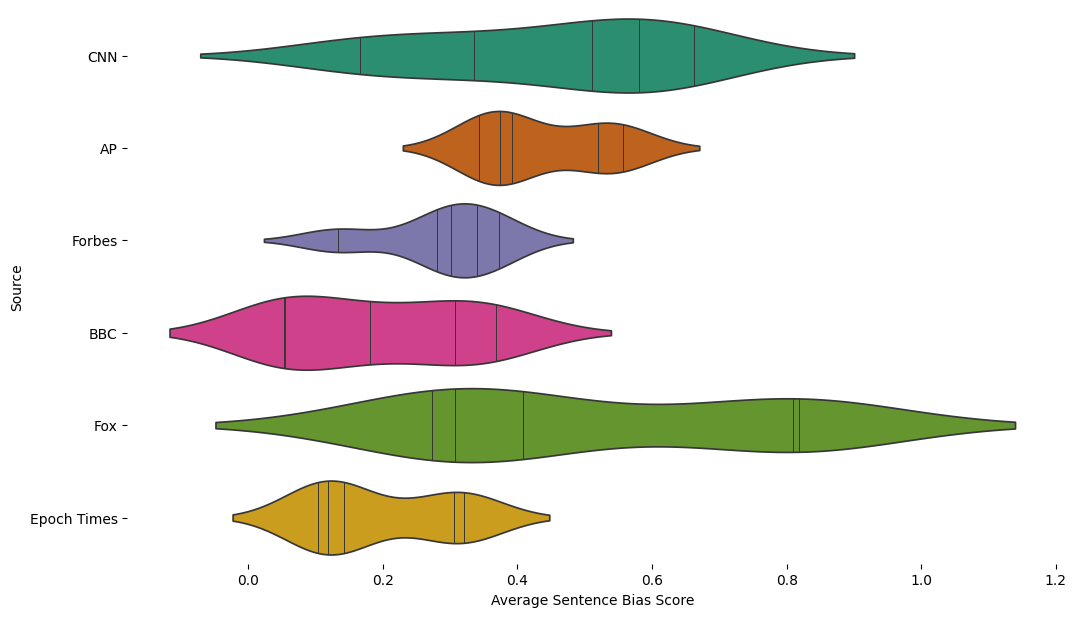

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(benchmark_df['Source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(benchmark_df, x='Average Sentence Bias Score', y='Source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [37]:
# Print accuracy report for logistic regression
logreg_df = benchmark_df[benchmark_df['Model'] == 'logreg']
print_accuracy_report(logreg_df['Benchmark Label'], logreg_df['Model Predicted Label'])

Accuracy: 0.433

              precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.86      0.27      0.41        22
           2       0.33      1.00      0.50         5

    accuracy                           0.43        30
   macro avg       0.48      0.65      0.43        30
weighted avg       0.71      0.43      0.42        30



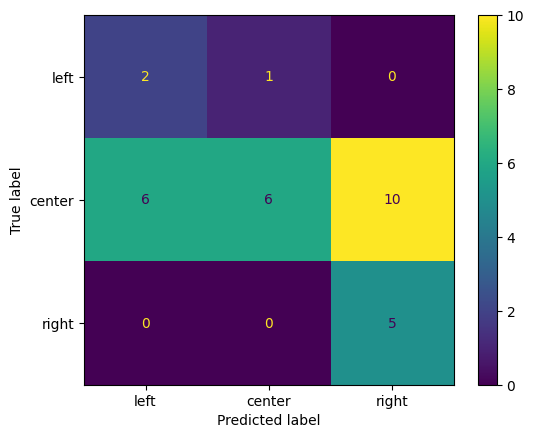

In [38]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(logreg_df['Benchmark Label'], logreg_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [39]:
# Print accuracy report for multinomial naive bayes
mnb_df = benchmark_df[benchmark_df['Model'] == 'mnb']
print_accuracy_report(mnb_df['Benchmark Label'], mnb_df['Model Predicted Label'])

Accuracy: 0.567

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         3
           1       1.00      0.50      0.67        22
           2       0.43      0.60      0.50         5

    accuracy                           0.57        30
   macro avg       0.56      0.70      0.52        30
weighted avg       0.83      0.57      0.61        30



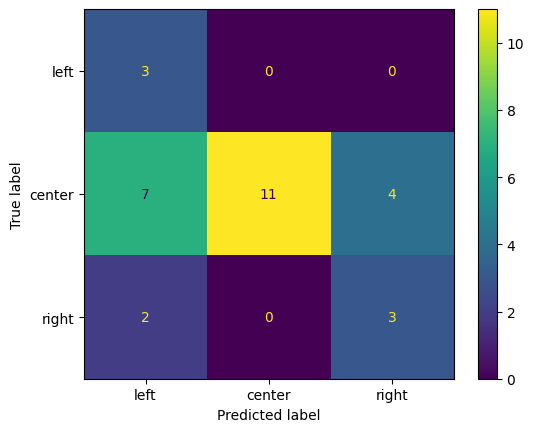

In [40]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(mnb_df['Benchmark Label'], mnb_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [41]:
# Adjust the boundary of benchmark ratings of left, center, and right.
# Left: -6 to -1
# Center: -0.99 to 0.99
# Right: 1 to 6
# Add a new column called 'Benchmark Label Adjusted' where the value will be 0 if Allsides Rating is between -6 to -1, 1 if -0.99 to 0.99, and 2 if 1 to 6

def adjust_benchmark_label(x):
  if x >= -6 and x <= -1:
    return 0
  elif x >= -0.99 and x <= 0.99:
    return 1
  else:
    return 2

benchmark_df['Benchmark Label Adjusted'] = benchmark_df['Allsides Rating'].apply(adjust_benchmark_label)
benchmark_df.head()

,Source,Source Leaning,Model,Average Sentence Bias Score,Model Predicted Label,Benchmark Label,Allsides Rating,Topic,Benchmark Label Adjusted
0,CNN,0.5,logreg,0.335404,1,0,-2.5,Candidates,0
1,CNN,0.5,mnb,0.335404,0,0,-2.5,Candidates,0
2,CNN,0.5,logreg,0.510204,1,1,-1.5,Society & Culture,0
3,CNN,0.5,mnb,0.510204,0,1,-1.5,Society & Culture,0
4,CNN,0.5,logreg,0.166667,0,1,-1.5,Economy & Foreign Affairs,0


In [42]:
# Print accuracy report for logistic regression
logreg_df = benchmark_df[benchmark_df['Model'] == 'logreg']
print_accuracy_report(logreg_df['Benchmark Label Adjusted'], logreg_df['Model Predicted Label'])

Accuracy: 0.567

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.43      0.30      0.35        10
           2       0.60      0.90      0.72        10

    accuracy                           0.57        30
   macro avg       0.55      0.57      0.54        30
weighted avg       0.55      0.57      0.54        30



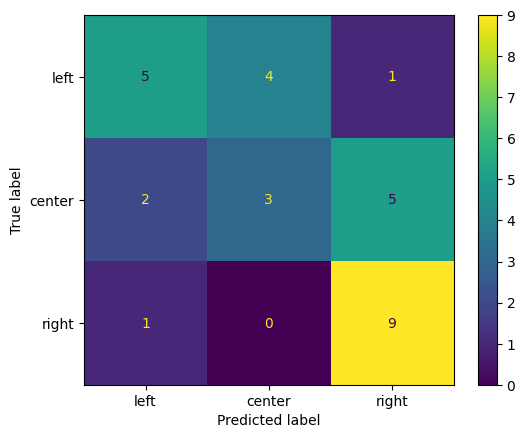

In [43]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(logreg_df['Benchmark Label Adjusted'], logreg_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [44]:
# Print accuracy report for multinomial naive bayes
mnb_df = benchmark_df[benchmark_df['Model'] == 'mnb']
print_accuracy_report(mnb_df['Benchmark Label Adjusted'], mnb_df['Model Predicted Label'])

Accuracy: 0.600

              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.55      0.60      0.57        10
           2       0.86      0.60      0.71        10

    accuracy                           0.60        30
   macro avg       0.63      0.60      0.61        30
weighted avg       0.63      0.60      0.61        30



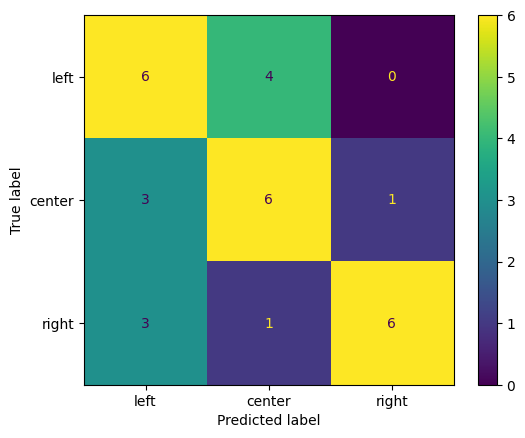

In [45]:
# Confusion Matrix for logistc regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create a confusion matrix
cm = confusion_matrix(mnb_df['Benchmark Label Adjusted'], mnb_df['Model Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['left', 'center', 'right'])
disp.plot()
plt.show()

In [46]:
# Calculate the average of Average Sentence Bias Score for each source leaning
benchmark_df[['Source Leaning', 'Average Sentence Bias Score']].groupby('Source Leaning').mean()

,Average Sentence Bias Score
Source Leaning,
0.0,0.437374
0.5,0.451264
1.0,0.239459
1.5,0.198529
2.0,0.523409


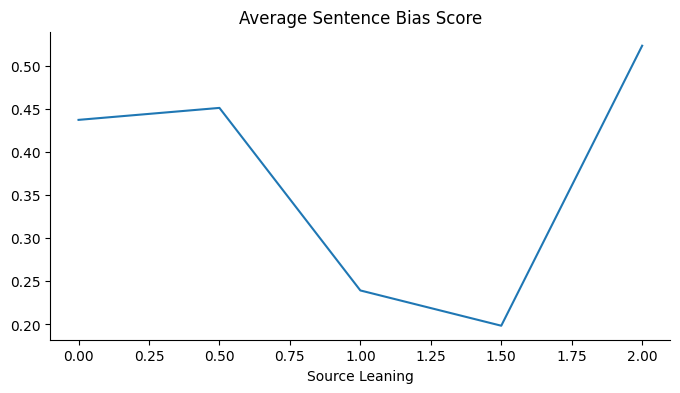

In [48]:
# Plot the Average Sentence Bias Score against Source Leaning
temp_df = benchmark_df[['Source Leaning', 'Average Sentence Bias Score']].groupby('Source Leaning').mean()
temp_df['Average Sentence Bias Score'].plot(kind='line', figsize=(8, 4), title='Average Sentence Bias Score')
plt.gca().spines[['top', 'right']].set_visible(False)